In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from skimage.io import imshow
import pathlib

from IPython.display import display
tf.__version__

'2.3.0'

In [2]:
data_root_orig = tf.keras.utils.get_file(origin='http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar',
                                         fname='photo', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

C:\Users\Doffy\.keras\datasets\photo


In [4]:
import random
data_path = pathlib.Path('./Images')
train_images = list(data_path.glob('*/*'))  
train_images = [str(path) for path in train_images]  # 所有图片路径的列表
random.shuffle(train_images)  # 打散

image_count = len(train_images)
print(image_count)

label_names = sorted(item.name for item in data_path.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))
train_labels = [label_to_index[pathlib.Path(path).parent.name] for path in train_images]



20580


In [6]:
'''list_lena = []
import matplotlib.image as mpimg
for i in range(image_count):
    lena = mpimg.imread(train_images[i])
    list_lena.append(lena)'''


'list_lena = []\nimport matplotlib.image as mpimg\nfor i in range(image_count):\n    lena = mpimg.imread(train_images[i])\n    list_lena.append(lena)'

In [5]:
#list_lena = np.array(list_lena)
#list_lena.dtype, list_lena.shape

In [60]:
#ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
ds

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>

In [7]:
ds = tf.data.Dataset.from_tensor_slices((train_images))#, train_labels))

def load_and_preprocess_from_path_label(path):#, label):
    image = tf.io.read_file(path)  # 讀取圖片
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [32, 32])  
    image = (image - 127.5) / 127.5 # Normalize the images to [-1, 1]

    return image#, label

image_label_ds  = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: (32, 32, 3), types: tf.float32>

In [6]:
#train_images = np.array(train_images)
#train_images.dtype, train_images.shape

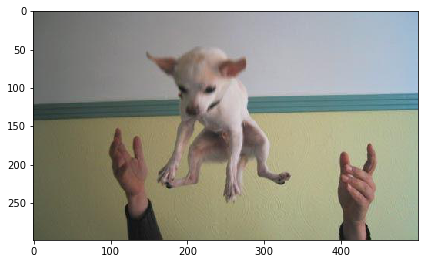

In [7]:
imshow(train_images[2])

In [151]:
def img_to_float(img):
  return (np.float32(img)-127.5)/127.5
def img_to_uint8(img):
  return np.uint8(img*127.5+128).clip(0, 255)

In [8]:
#train_img_f32 = img_to_float(list_lena)
#imshow(img_to_uint8(train_img_f32[30]))

In [9]:
#BUFFER_SIZE = train_img_f32.shape[0]
BATCH_SIZE = 32

#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(image_count).batch(BATCH_SIZE)
train_dataset = image_label_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [10]:
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, Conv2D
latent_dim = 64
generator = tf.keras.Sequential([
    Dense(4*4*256, use_bias=False, input_shape=(latent_dim,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((4, 4, 256)),
    Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh')
]
)

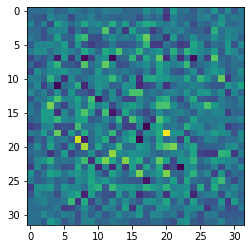

In [11]:
noise = tf.random.normal([BATCH_SIZE, latent_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])#, cmap='gray')

In [12]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten
discriminator =  tf.keras.Sequential([
   Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(32,32, 3)),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Flatten(),
   Dense(1)]
)

In [13]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(generated_output):
    return loss_fn(tf.ones_like(generated_output), generated_output)

In [14]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = loss_fn(tf.ones_like(real_output), real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = loss_fn(tf.zeros_like(generated_output), generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
EPOCHS = 50
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 latent_dim])

In [17]:
@tf.function
def train_step(images):
   # generating noise from a normal distribution
      noise = tf.random.normal([BATCH_SIZE, latent_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      return gen_loss, disc_loss

In [18]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap= None)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [ ]:
for epoch in range(30):
  start_time = time.time()
  loss = []
  for images in train_dataset:
      images = images.numpy()
      images = images.reshape(1,32,32,3)
      loss.append(np.array(train_step(images)))
  fake = generator(random_vector_for_generation, training=False)
  fake_concat = np.transpose(img_to_uint8(fake), [1,0,2,3]).reshape((32,-1,3))

  generate_and_save_images(generator,
                             epoch + 1,
                             random_vector_for_generation)
  print(epoch, np.mean(loss, axis=0), time.time()-start_time)
  
  display(PIL.Image.fromarray(fake_concat))
  
generate_and_save_images(generator,
                             epoch ,
                             random_vector_for_generation) 